# Importation des bibliothèques

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import shapiro
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from typing import Dict, Any, Tuple




# Préparation des données

## Lecture des données

In [4]:
participants_train = pd.read_csv(os.path.join("data", "train_participants.csv" ))
participants_train["set"] = 'train'
participants_test = pd.read_csv(os.path.join("data", "test_participants.csv" ))
participants_test["set"] = 'test'
participants = pd.concat([participants_train, participants_test])

In [5]:
rois_train = pd.read_csv(os.path.join("data", "train_rois.csv" )).loc[:, 'l3thVen_GM_Vol':]
rois_test = pd.read_csv(os.path.join("data", "test_rois.csv" )).loc[:, 'l3thVen_GM_Vol':]
rois = pd.concat([rois_train, rois_test])

## Réduction de dimensionnalité

                 sum_sq     df          F        PR(>F)
diagnosis   2606.207928    1.0  29.245287  9.808873e-08
Residual   45538.013350  511.0        NaN           NaN
                 sum_sq     df          F    PR(>F)
diagnosis    791.094363    1.0  10.876419  0.001042
Residual   37167.493121  511.0        NaN       NaN


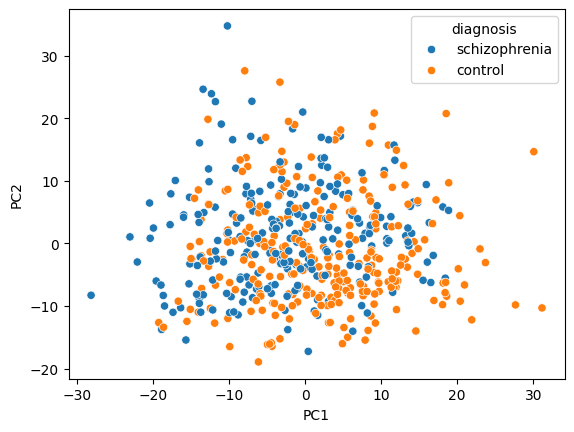

In [6]:
PCs = PCA(n_components=2).fit_transform(rois)
participants['PC1'], participants['PC2']  = PCs[:, 0], PCs[:, 1]

sns.scatterplot (x="PC1", y="PC2", hue="diagnosis",  data=participants)
oneway = smf.ols('PC1 ~ diagnosis', participants).fit()
print(sm.stats.anova_lm(oneway, typ=2))
oneway = smf.ols('PC2 ~ diagnosis', participants).fit()
print(sm.stats.anova_lm(oneway, typ=2))

Nous effectuons une réduction de dimensionnalité avec l'Analyse en Composantes Principales (PCA) sur les données des ROIs pour extraire deux principales composantes (PC1 et PC2), ajoutées au DataFrame des participants. Nous visualisons ensuite les données dans un graphique (PC1 vs PC2) coloré par le diagnostic (diagnosis). Enfin, des tests ANOVA évaluent si les composantes principales sont significativement liées au diagnostic.

## Statistiques descriptives

In [7]:
participants.head()

,participant_id,session,sex,age,diagnosis,study,site,TIV,CSF_Vol,GM_Vol,WM_Vol,set,PC1,PC2
0,CH7098a,V1,0.0,20.0,schizophrenia,SCHIZCONNECT-VIP,NU,1712.357084,375.529152,747.089338,586.391159,train,15.931013,9.401301
1,A00024535,V1,0.0,26.0,control,SCHIZCONNECT-VIP,MRN,1700.601735,399.493745,721.128411,579.446172,train,10.948818,15.705874
2,CC7563,V1,1.0,28.0,control,SCHIZCONNECT-VIP,WUSTL,1449.327365,220.825294,661.028439,566.500051,train,5.949018,-7.074739
3,CC3945,V1,1.0,21.0,control,SCHIZCONNECT-VIP,WUSTL,1184.699000,201.579922,560.051329,423.016129,train,-10.141634,-11.967404
4,CH8853b,V1,1.0,21.0,control,SCHIZCONNECT-VIP,NU,1518.198466,291.544632,705.384606,520.807601,train,9.292254,2.343498


In [8]:
participants.shape

(513, 14)

In [9]:
# Remplacer "schizophrenia" par 1 et "control" par 0 dans la colonne 'diagnosis'
participants['diagnosis'] = participants['diagnosis'].replace({'schizophrenia': 1, 'control': 0})

# Vérification du changement
print(participants['diagnosis'].value_counts())

diagnosis
0    277
1    236
Name: count, dtype: int64


C:\Users\salma\AppData\Local\Temp\ipykernel_232\1074566252.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  participants['diagnosis'] = participants['diagnosis'].replace({'schizophrenia': 1, 'control': 0})


In [10]:
# Liste des colonnes numériques
numerical_columns = ['age', 'TIV', 'CSF_Vol', 'GM_Vol', 'WM_Vol', 'PC1', 'PC2']
# Liste des colonnes catégorielles
categorical_columns = ['sex', 'site']

In [11]:
participants.isnull().sum()

participant_id    0
session           0
sex               0
age               0
diagnosis         0
study             0
site              0
TIV               0
CSF_Vol           0
GM_Vol            0
WM_Vol            0
set               0
PC1               0
PC2               0
dtype: int64

In [12]:
participants.dtypes

participant_id     object
session            object
sex               float64
age               float64
diagnosis           int64
study              object
site               object
TIV               float64
CSF_Vol           float64
GM_Vol            float64
WM_Vol            float64
set                object
PC1               float64
PC2               float64
dtype: object

In [13]:
participants.nunique()

participant_id    513
session             1
sex                 2
age                52
diagnosis           2
study               1
site                3
TIV               513
CSF_Vol           513
GM_Vol            513
WM_Vol            513
set                 2
PC1               513
PC2               513
dtype: int64

In [14]:
participants[numerical_columns].describe()

,age,TIV,CSF_Vol,GM_Vol,WM_Vol,PC1,PC2
count,513.000000,513.000000,513.000000,513.000000,513.000000,5.130000e+02,5.130000e+02
mean,33.148148,1426.607843,284.849383,625.735858,514.981154,4.639996e-15,8.241188e-16
std,12.600746,149.019602,68.807070,74.945900,63.742644,9.696993e+00,8.610335e+00
min,14.000000,1071.499793,144.985388,428.563675,359.708027,-2.811811e+01,-1.890849e+01
25%,23.000000,1327.256106,232.636949,570.983541,472.661075,-6.981725e+00,-6.460687e+00
50%,29.000000,1420.479557,275.634286,620.268996,509.191309,-3.714784e-01,-1.081647e+00
75%,43.000000,1531.174963,325.010302,677.852937,559.486417,7.086884e+00,5.288149e+00
max,66.000000,1852.574833,570.503425,889.396408,741.492388,3.113500e+01,3.472794e+01


In [15]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 513 entries, 0 to 102
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   participant_id  513 non-null    object 
 1   session         513 non-null    object 
 2   sex             513 non-null    float64
 3   age             513 non-null    float64
 4   diagnosis       513 non-null    int64  
 5   study           513 non-null    object 
 6   site            513 non-null    object 
 7   TIV             513 non-null    float64
 8   CSF_Vol         513 non-null    float64
 9   GM_Vol          513 non-null    float64
 10  WM_Vol          513 non-null    float64
 11  set             513 non-null    object 
 12  PC1             513 non-null    float64
 13  PC2             513 non-null    float64
dtypes: float64(8), int64(1), object(5)
memory usage: 60.1+ KB


In [16]:
participants.duplicated().sum()

np.int64(0)

## Visualisation des données

         age                                                    
       count       mean        std   min   25%   50%   75%   max
set                                                             
test   103.0  33.466019  12.809935  14.0  23.5  31.0  41.0  66.0
train  410.0  33.068293  12.562225  15.0  22.0  29.0  43.0  65.0
           age
set   sex     
test  0.0   65
      1.0   38
train 0.0  257
      1.0  153


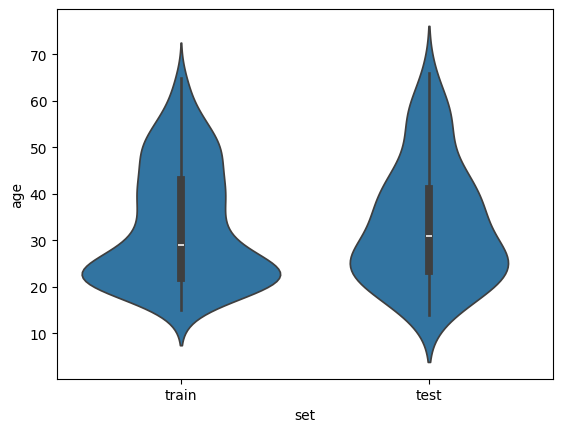

In [17]:
# Visualiser la distribution de l'âge par sexe et set
sns.violinplot(x="set", y="age", data=participants)
print(participants[["age", "set"]].groupby("set").describe())
print(participants[["set", "sex", "age"]].groupby(["set", "sex"]).count())

C:\Users\salma\AppData\Local\Temp\ipykernel_232\1528571415.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=participants["diagnosis"], palette="Set1")


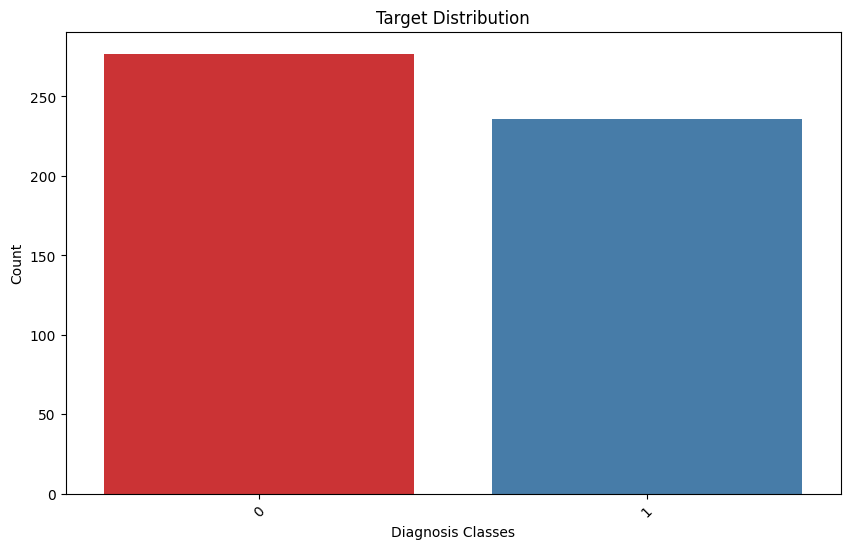

In [18]:
# Visualiser la distribution de la cible dans l'ensemble des données
plt.figure(figsize=(10, 6))
sns.countplot(x=participants["diagnosis"], palette="Set1")
plt.title("Target Distribution")
plt.xlabel("Diagnosis Classes")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

C:\Users\salma\AppData\Local\Temp\ipykernel_232\491396768.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=participants, x='diagnosis', y=col, palette="Set3", inner="quartile", ax=axes[i])
C:\Users\salma\AppData\Local\Temp\ipykernel_232\491396768.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=participants, x='diagnosis', y=col, palette="Set3", inner="quartile", ax=axes[i])
C:\Users\salma\AppData\Local\Temp\ipykernel_232\491396768.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=participants, x='diagnosis', 

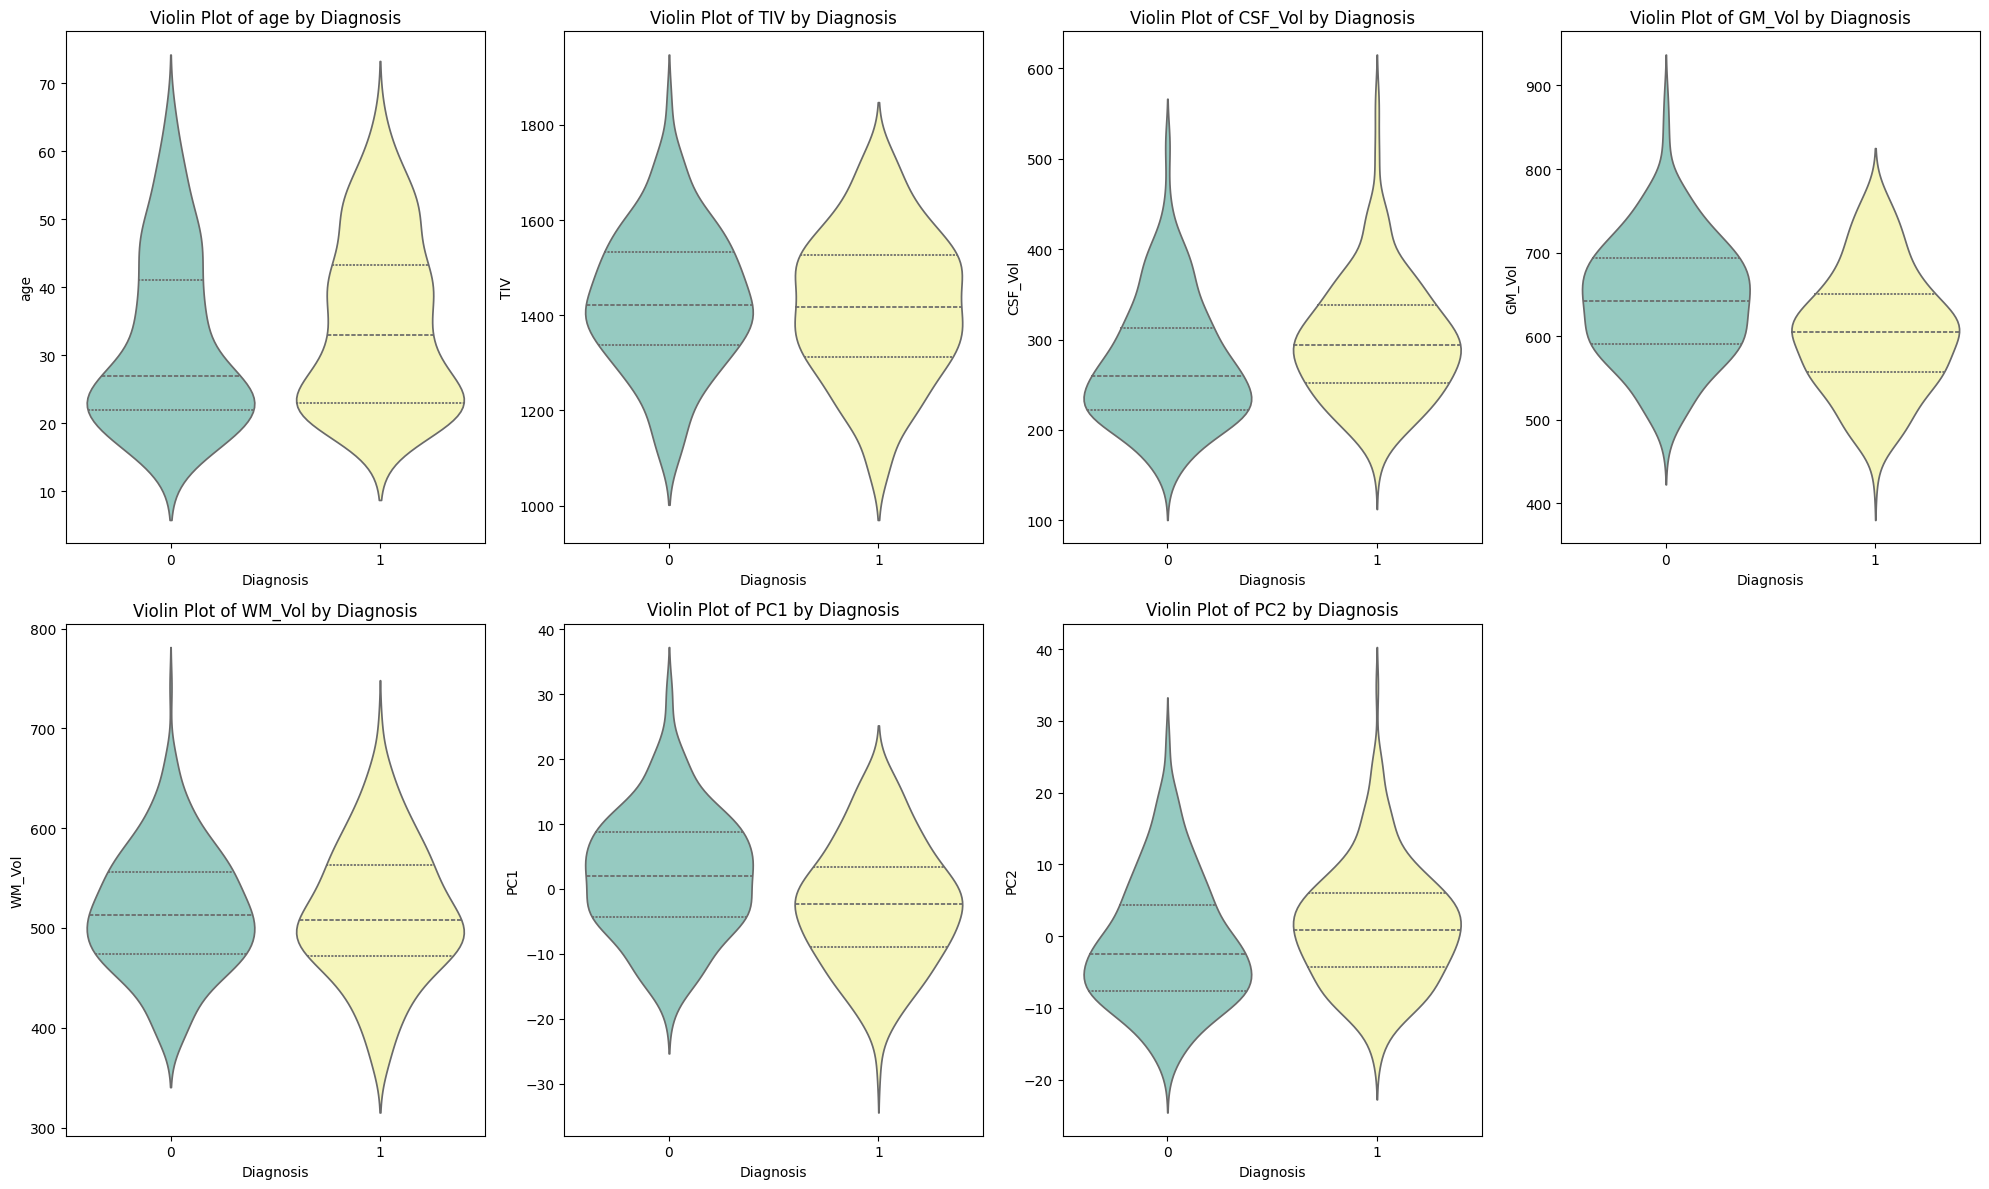

In [19]:
# Visualiser les distributions des variables numériques en violin plots
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    if i < len(axes):
        sns.violinplot(data=participants, x='diagnosis', y=col, palette="Set3", inner="quartile", ax=axes[i])
        axes[i].set_title(f"Violin Plot of {col} by Diagnosis")
        axes[i].set_xlabel("Diagnosis")
        axes[i].set_ylabel(col)

# Supprimer les axes inutilisés 
for j in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


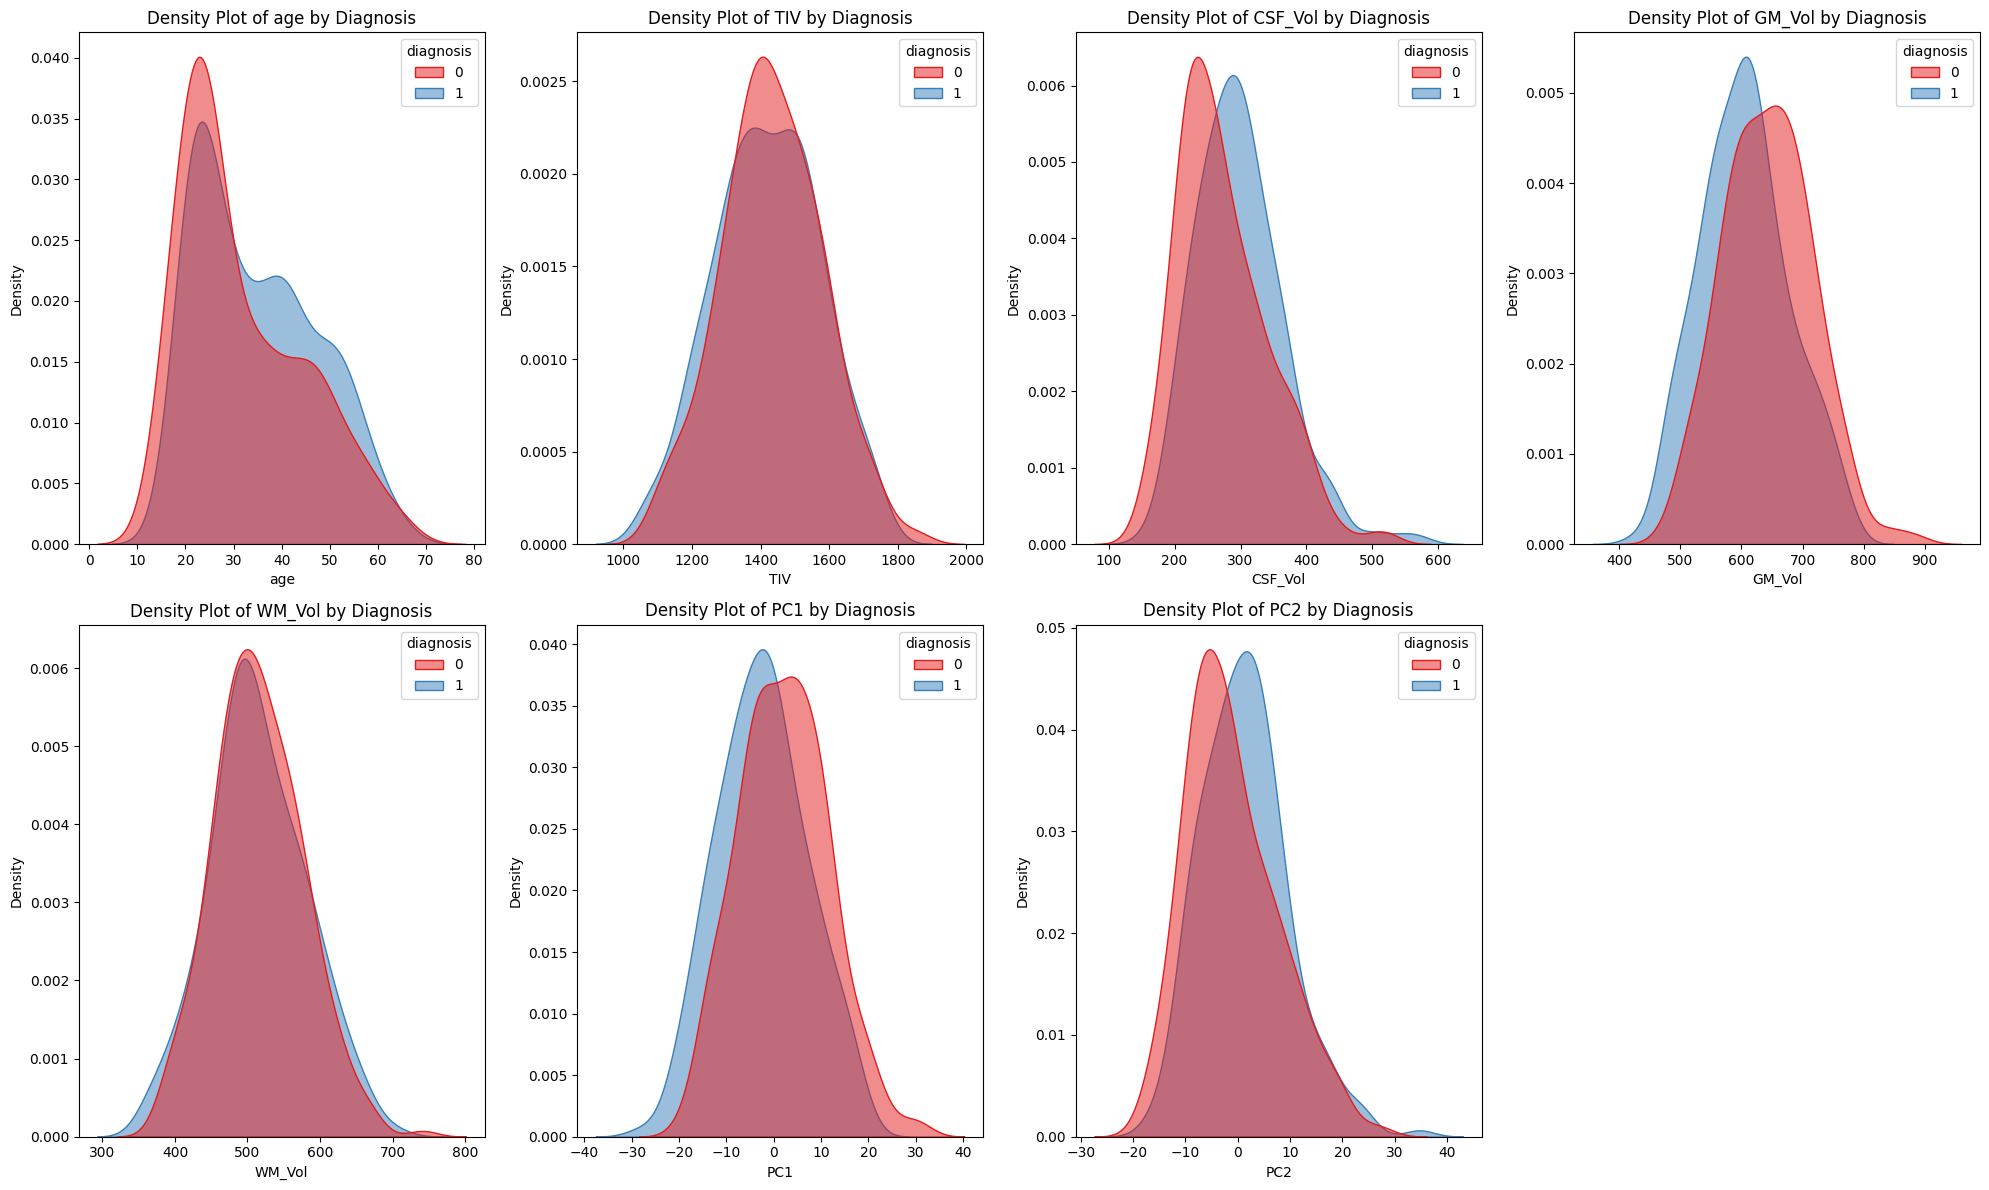

In [20]:
# Visualiser les densités des variables numériques en fonction de la target
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    if i < len(axes):
        sns.kdeplot(data=participants, x=col, hue='diagnosis', fill=True, common_norm=False, 
                    palette="Set1", alpha=0.5, ax=axes[i])
        axes[i].set_title(f"Density Plot of {col} by Diagnosis")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Density")

# Supprimer les axes inutilisés 
for j in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

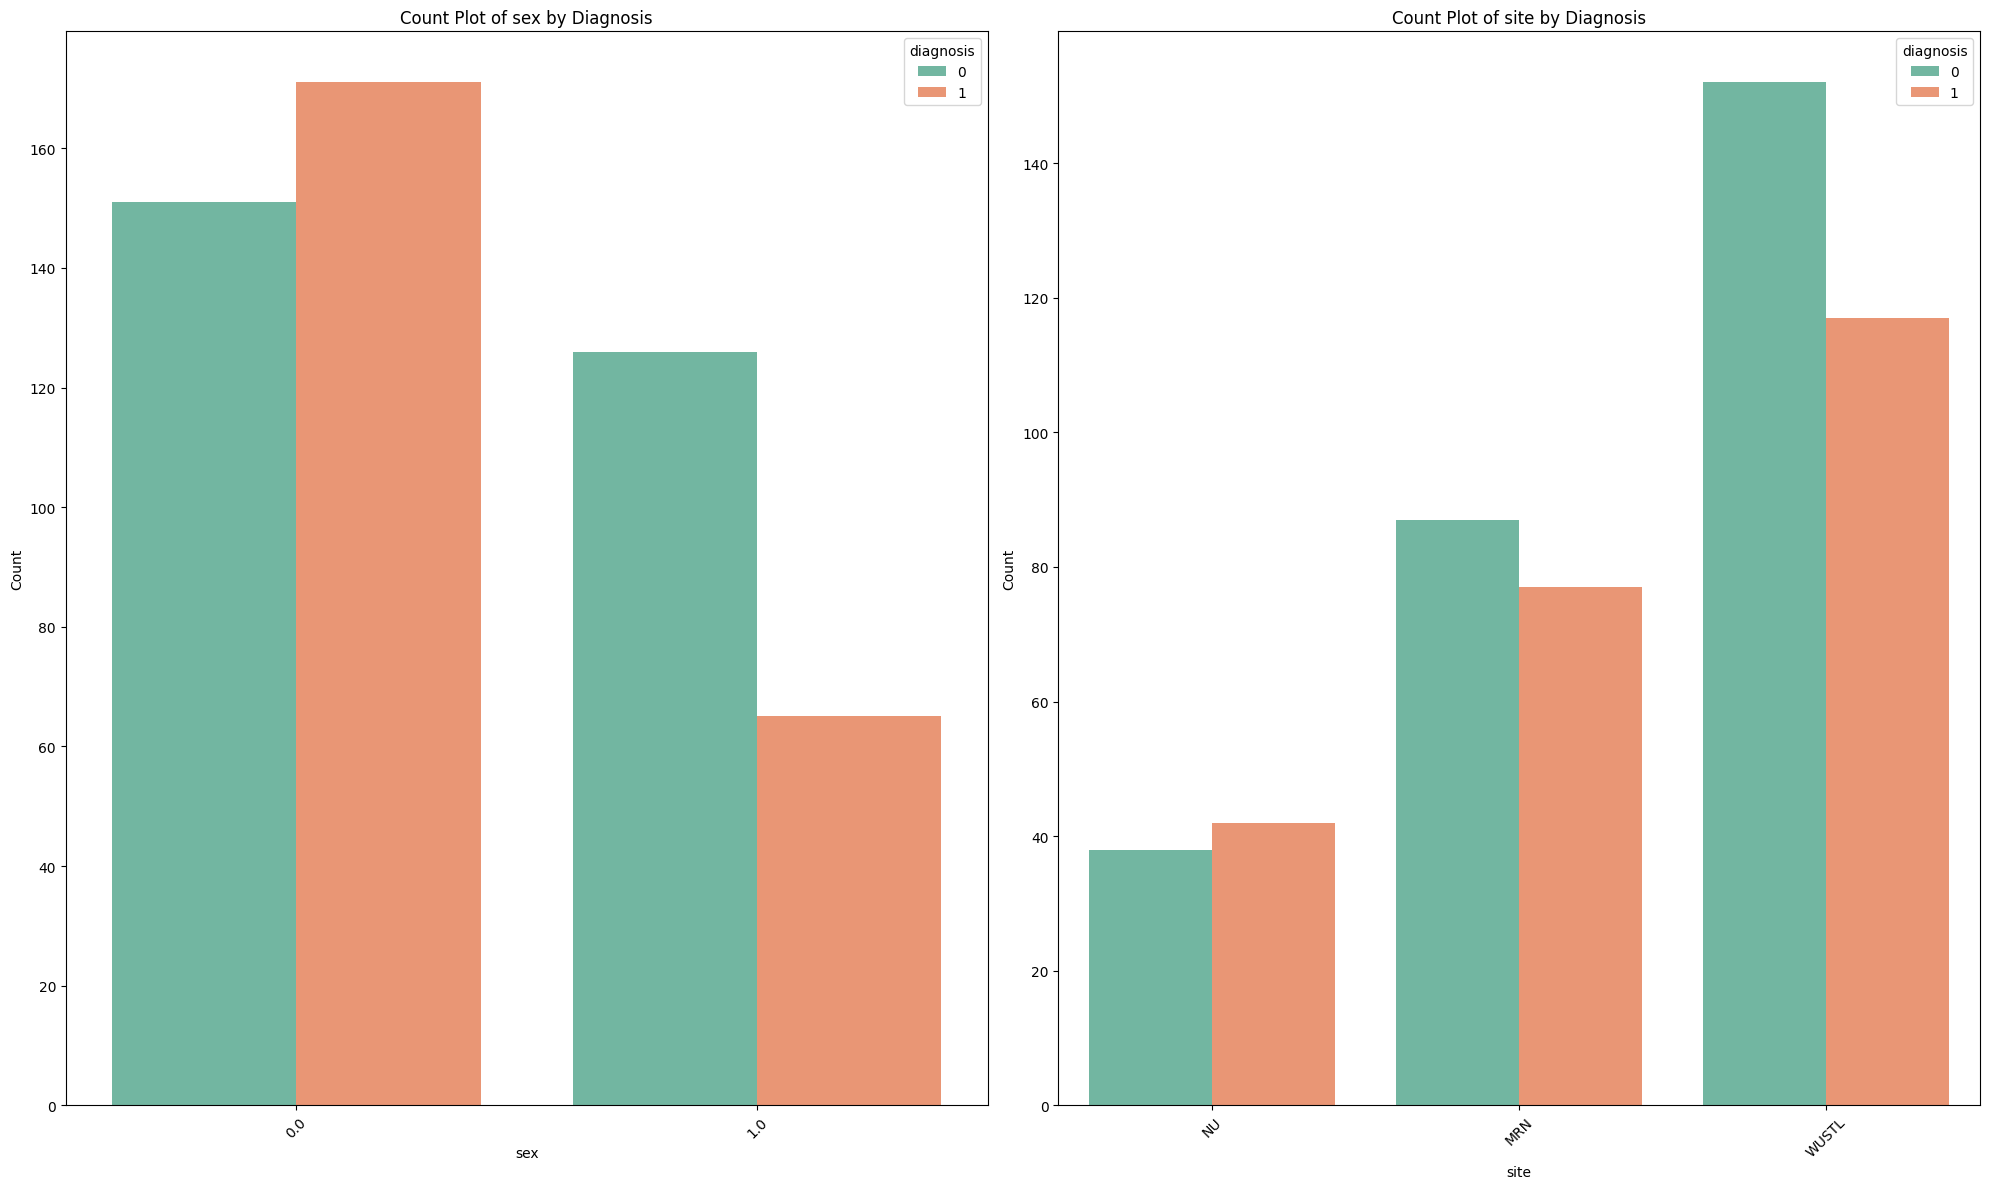

In [ ]:
# Visualiser les distributions des variables catégorielles
fig, axes = plt.subplots(1, 2, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    if i < len(axes):
        sns.countplot(data=participants, x=col, hue='diagnosis', palette="Set2", ax=axes[i])
        axes[i].set_title(f"Count Plot of {col} by Diagnosis")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")
        axes[i].tick_params(axis='x', rotation=45)

# Supprimer les axes inutilisés 
for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Détection des outliers

In [22]:
def detect_outliers(df):
    outliers = {}
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Détecter les outliers
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    return outliers

# Utilisation de la fonction sur le DataFrame participants
outliers = detect_outliers(participants)

# Afficher les outliers détectés
for col, outlier_data in outliers.items():
    print(f"Outliers detected for {col}:")
    print(outlier_data)

Outliers detected for sex:
Empty DataFrame
Columns: [participant_id, session, sex, age, diagnosis, study, site, TIV, CSF_Vol, GM_Vol, WM_Vol, set, PC1, PC2]
Index: []
Outliers detected for age:
Empty DataFrame
Columns: [participant_id, session, sex, age, diagnosis, study, site, TIV, CSF_Vol, GM_Vol, WM_Vol, set, PC1, PC2]
Index: []
Outliers detected for diagnosis:
Empty DataFrame
Columns: [participant_id, session, sex, age, diagnosis, study, site, TIV, CSF_Vol, GM_Vol, WM_Vol, set, PC1, PC2]
Index: []
Outliers detected for TIV:
    participant_id session  sex   age  diagnosis             study   site  \
70          CC3915      V1  0.0  15.0          0  SCHIZCONNECT-VIP  WUSTL   
390      A00025969      V1  0.0  26.0          0  SCHIZCONNECT-VIP    MRN   

             TIV     CSF_Vol      GM_Vol      WM_Vol    set        PC1  \
70   1847.634820  366.125365  889.396408  591.308518  train  30.061993   
390  1852.574833  331.603268  778.460420  741.492388  train  18.880690   

           

C:\Users\salma\AppData\Local\Temp\ipykernel_232\2026484095.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=participants[col], palette="Set1")
C:\Users\salma\AppData\Local\Temp\ipykernel_232\2026484095.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=participants[col], palette="Set1")
C:\Users\salma\AppData\Local\Temp\ipykernel_232\2026484095.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=participants[col], palette="Set1")
C:\Users\salma\AppData\Local\Temp\ipykernel_232\2026484095.py:6: FutureWarning: 

Passing `palette` wit

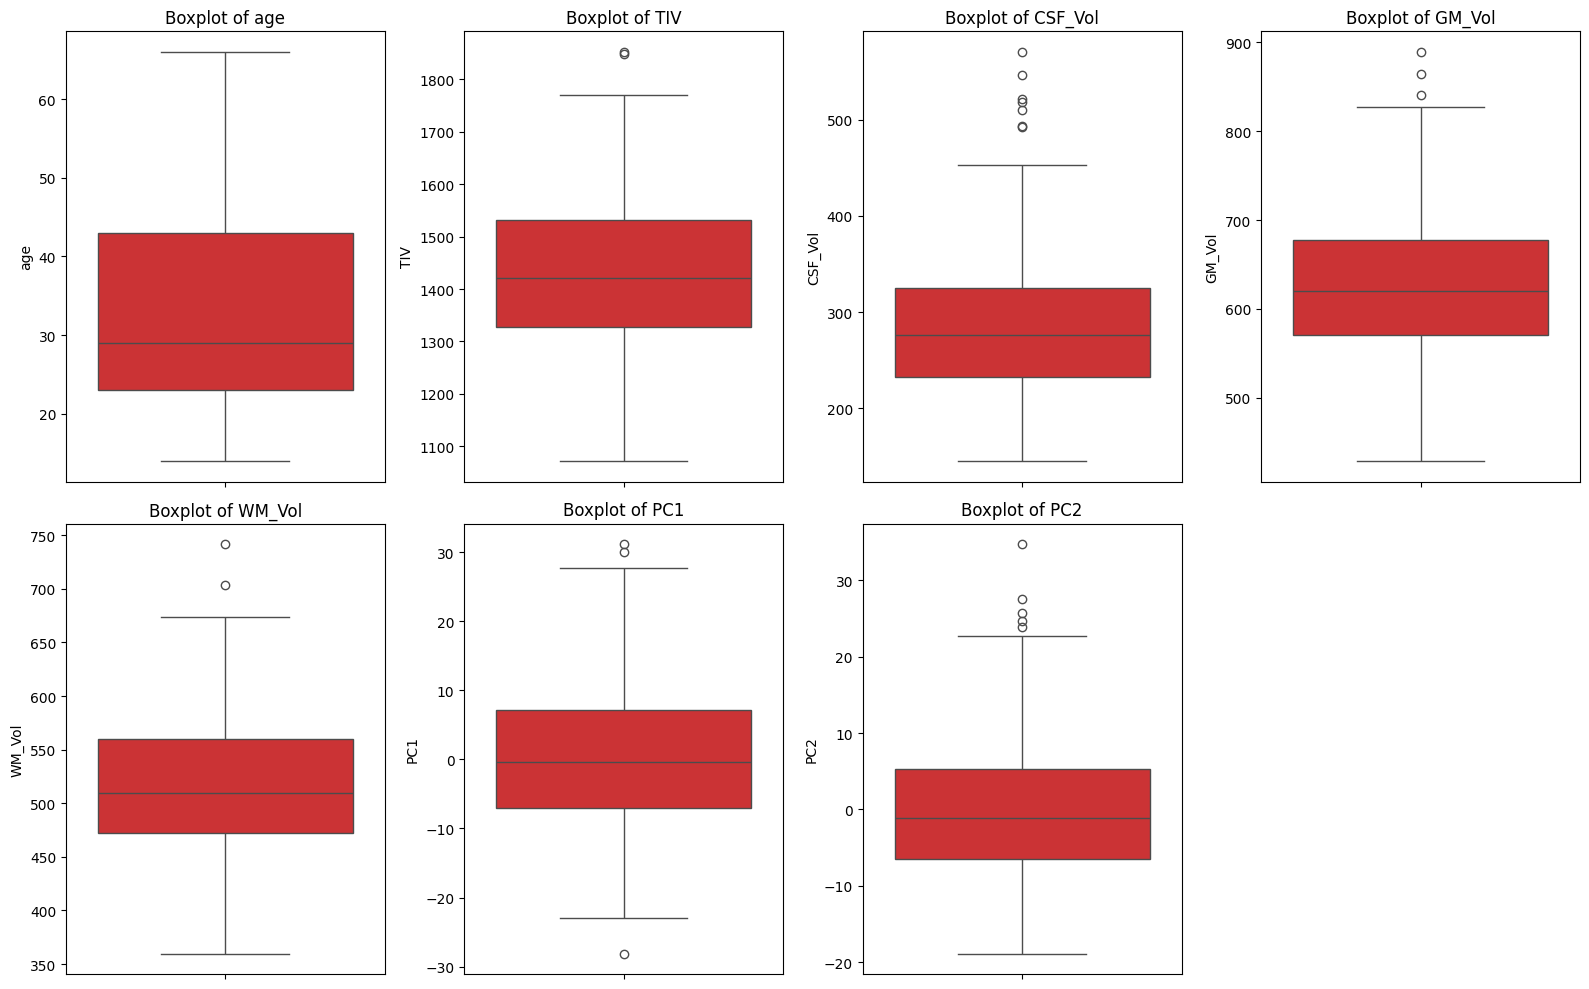

In [23]:
plt.figure(figsize=(16, 10))

# Afficher un boxplot pour chaque variable numérique 
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 4, i)  
    sns.boxplot(y=participants[col], palette="Set1")
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)

plt.tight_layout()  
plt.show()

## Analyse de la corrélation entre les variables

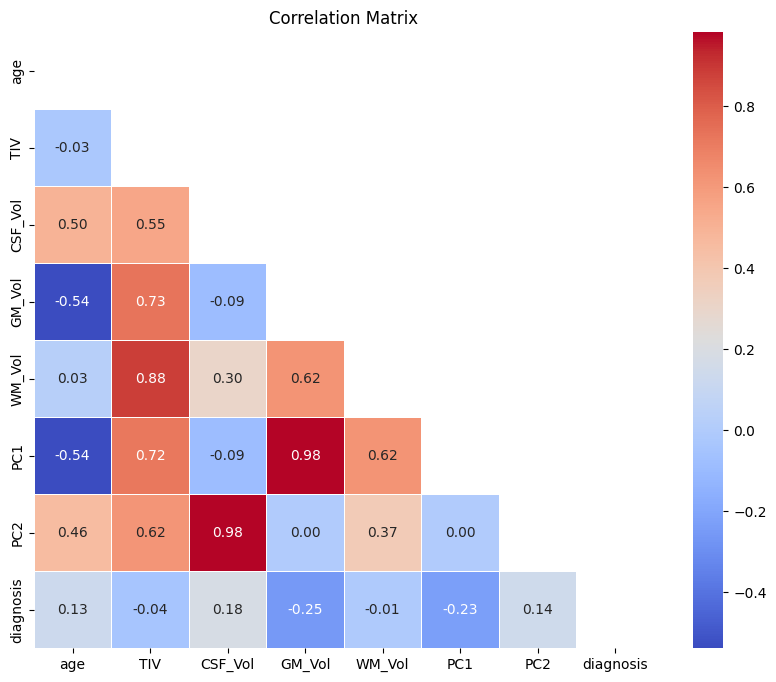

In [24]:
# Calculer la matrice de corrélation
correlation_matrix = participants[numerical_columns + ['diagnosis']].corr()

# Masquer la partie supérieure de la matrice (y compris la diagonale)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Afficher la matrice de corrélation inférieure sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Test de normalité des données

In [25]:
# Test de normalité de Shapiro-Wilk pour chaque variable numérique
for col in numerical_columns:
    stat, p_value = shapiro(participants[col])
    print(f"Shapiro-Wilk Test for {col}: Statistics={stat:.4f}, p-value={p_value:.4f}")
    if p_value > 0.05:
        print(f"{col} semble suivre une distribution normale (p-value > 0.05)\n")
    else:
        print(f"{col} ne semble pas suivre une distribution normale (p-value <= 0.05)\n")

Shapiro-Wilk Test for age: Statistics=0.9268, p-value=0.0000
age ne semble pas suivre une distribution normale (p-value <= 0.05)

Shapiro-Wilk Test for TIV: Statistics=0.9963, p-value=0.2807
TIV semble suivre une distribution normale (p-value > 0.05)

Shapiro-Wilk Test for CSF_Vol: Statistics=0.9645, p-value=0.0000
CSF_Vol ne semble pas suivre une distribution normale (p-value <= 0.05)

Shapiro-Wilk Test for GM_Vol: Statistics=0.9943, p-value=0.0528
GM_Vol semble suivre une distribution normale (p-value > 0.05)

Shapiro-Wilk Test for WM_Vol: Statistics=0.9949, p-value=0.0881
WM_Vol semble suivre une distribution normale (p-value > 0.05)

Shapiro-Wilk Test for PC1: Statistics=0.9966, p-value=0.3511
PC1 semble suivre une distribution normale (p-value > 0.05)

Shapiro-Wilk Test for PC2: Statistics=0.9785, p-value=0.0000
PC2 ne semble pas suivre une distribution normale (p-value <= 0.05)



## Séparation des données en train/test

In [26]:
# Sélectionner les colonnes pour les caractéristiques (features) et la cible (target)
target_column = "diagnosis"
feature_columns = ['participant_id', 'session', 'sex', 'age', 'study', 'site', 'TIV', 'CSF_Vol', 'GM_Vol', 'WM_Vol', 'set', 'PC1', 'PC2']

# Diviser les données en ensembles d'entraînement et de test en fonction de la colonne 'set'
df_train = participants[participants['set'] == 'train']
df_test = participants[participants['set'] == 'test']

# Extraire les caractéristiques (X) et la cible (y) pour l'entraînement et le test
X_train = df_train[feature_columns].copy()
y_train = df_train[target_column]
X_test = df_test[feature_columns].copy()
y_test = df_test[target_column]

# Vérification des dimensions
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (410, 13), y_train shape: (410,)
X_test shape: (103, 13), y_test shape: (103,)


In [27]:
# Supprimer les colonnes 'session', 'study' et 'set' dans X_train et X_test
X_train = X_train.drop(columns=['participant_id', 'session', 'study', 'set'])
X_test = X_test.drop(columns=['participant_id','session', 'study', 'set'])

# Vérification des dimensions
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (410, 9), y_train shape: (410,)
X_test shape: (103, 9), y_test shape: (103,)


C:\Users\salma\AppData\Local\Temp\ipykernel_232\980971582.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="Set2", ax=axes[0])
C:\Users\salma\AppData\Local\Temp\ipykernel_232\980971582.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette="Set2", ax=axes[1])


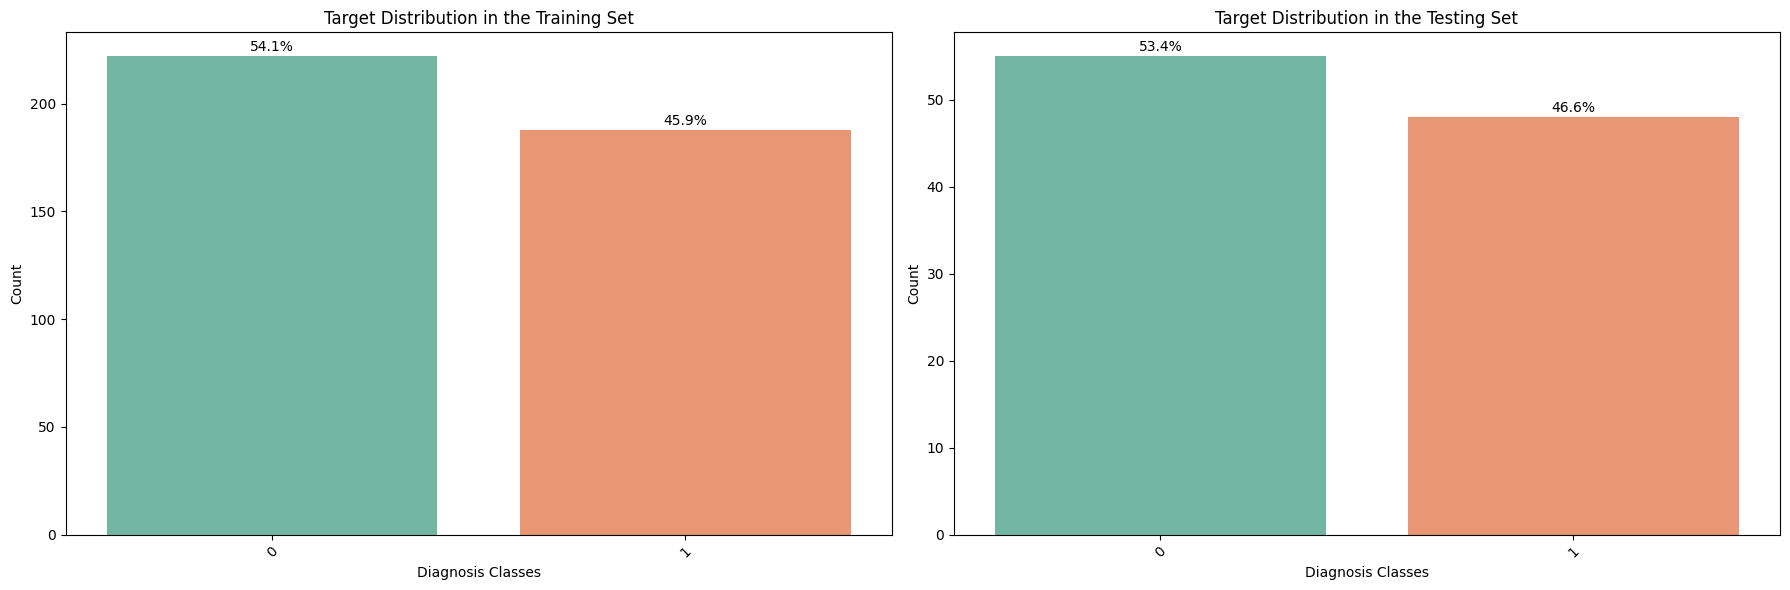

In [28]:
# Visualiser la target dans les ensembles de train et de test
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Distribution de la target dans l'ensemble d'entraînement 
sns.countplot(x=y_train, palette="Set2", ax=axes[0])
axes[0].set_title("Target Distribution in the Training Set")
axes[0].set_xlabel("Diagnosis Classes")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# Calculer les pourcentages pour l'ensemble d'entraînement
total_train = len(y_train)
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2., height + 0.01 * total_train, 
                 f'{height / total_train * 100:.1f}%', ha="center", va="center")

# Distribution de la target dans l'ensemble de test 
sns.countplot(x=y_test, palette="Set2", ax=axes[1])
axes[1].set_title("Target Distribution in the Testing Set")
axes[1].set_xlabel("Diagnosis Classes")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

# Calculer les pourcentages pour l'ensemble de test
total_test = len(y_test)
for p in axes[1].patches:
    height = p.get_height()
    axes[1].text(p.get_x() + p.get_width() / 2., height + 0.01 * total_test,  
                 f'{height / total_test * 100:.1f}%', ha="center", va="center")

# Ajuster les espacements
plt.tight_layout()
plt.show()


## Encodage des variables catégorielles

In [29]:
# Appliquer un encodage One-Hot à la variable 'site'
X_train = pd.get_dummies(X_train, columns=['site'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['site'], drop_first=True)

# Convertir les valeurs booléennes en entiers (1 et 0)
X_train = X_train.astype({col: 'int' for col in X_train.columns if 'site' in col})
X_test = X_test.astype({col: 'int' for col in X_test.columns if 'site' in col})

# Vérification du résultat
print(X_train.head())

   sex   age          TIV     CSF_Vol      GM_Vol      WM_Vol        PC1  \
0  0.0  20.0  1712.357084  375.529152  747.089338  586.391159  15.931013   
1  0.0  26.0  1700.601735  399.493745  721.128411  579.446172  10.948818   
2  1.0  28.0  1449.327365  220.825294  661.028439  566.500051   5.949018   
3  1.0  21.0  1184.699000  201.579922  560.051329  423.016129 -10.141634   
4  1.0  21.0  1518.198466  291.544632  705.384606  520.807601   9.292254   

         PC2  site_NU  site_WUSTL  
0   9.401301        1           0  
1  15.705874        0           0  
2  -7.074739        0           1  
3 -11.967404        0           1  
4   2.343498        1           0  


## Standardisation des données

In [30]:
# Initialiser le MinMaxScaler
scaler = MinMaxScaler()

# Appliquer le MinMaxScaler sur les colonnes numériques de X_train
X_train[['age', 'TIV', 'CSF_Vol', 'GM_Vol', 'WM_Vol']] = scaler.fit_transform(X_train[['age', 'TIV', 'CSF_Vol', 'GM_Vol', 'WM_Vol']])

# Appliquer le même scaler à X_test
X_test[['age', 'TIV', 'CSF_Vol', 'GM_Vol', 'WM_Vol']] = scaler.transform(X_test[['age', 'TIV', 'CSF_Vol', 'GM_Vol', 'WM_Vol']])

# Vérification des données après mise à l'échelle
print(X_train.head())



   sex   age       TIV   CSF_Vol    GM_Vol    WM_Vol        PC1        PC2  \
0  0.0  0.10  0.820481  0.541796  0.691196  0.587946  15.931013   9.401301   
1  0.0  0.22  0.805431  0.598114  0.634861  0.569496  10.948818  15.705874   
2  1.0  0.26  0.483728  0.178230  0.504445  0.535102   5.949018  -7.074739   
3  1.0  0.12  0.144927  0.133001  0.285326  0.153912 -10.141634 -11.967404   
4  1.0  0.12  0.571902  0.344425  0.600697  0.413712   9.292254   2.343498   

   site_NU  site_WUSTL  
0        1           0  
1        0           0  
2        0           1  
3        0           1  
4        1           0  


## Sélection des variables

In [ ]:
# Ajouter une constante pour l'interception du modèle
X_train_with_intercept = sm.add_constant(X_train)

# Fonction pour la sélection stepwise basée sur l'AIC
def stepwise_selection(X, y, direction='both', criterion='aic', verbose=True):
    """Fonction pour la sélection par étapes (forward/backward)"""
    
    initial_features = X.columns.tolist()
    best_features = initial_features.copy()
    while True:
        changed = False
        # Selection Forward 
        if direction in ['both', 'forward']:
            remaining_features = list(set(initial_features) - set(best_features))
            if remaining_features:
                aic_with_candidates = []
                for candidate in remaining_features:
                    features_to_test = best_features + [candidate]
                    X_test = X[features_to_test]
                    X_test = sm.add_constant(X_test)
                    model = sm.OLS(y, X_test).fit()
                    aic_with_candidates.append((candidate, model.aic))
                best_candidate = min(aic_with_candidates, key=lambda x: x[1])
                if best_candidate[1] < sm.OLS(y, sm.add_constant(X[best_features])).fit().aic:
                    best_features.append(best_candidate[0])
                    changed = True
                    if verbose:
                        print(f'Adding {best_candidate[0]} with AIC: {best_candidate[1]}')

        # Elimination Backward 
        if direction in ['both', 'backward']:
            if len(best_features) > 1:
                aic_with_drops = []
                for feature in best_features:
                    features_to_test = list(set(best_features) - {feature})
                    X_test = X[features_to_test]
                    X_test = sm.add_constant(X_test)
                    model = sm.OLS(y, X_test).fit()
                    aic_with_drops.append((feature, model.aic))
                worst_candidate = max(aic_with_drops, key=lambda x: x[1])
                if worst_candidate[1] < sm.OLS(y, sm.add_constant(X[best_features])).fit().aic:
                    best_features.remove(worst_candidate[0])
                    changed = True
                    if verbose:
                        print(f'Removing {worst_candidate[0]} with AIC: {worst_candidate[1]}')
        
        if not changed:
            break

    return best_features

# Appliquer la sélection par étapes
y_train_target = y_train  
best_features_stepwise = stepwise_selection(X_train_with_intercept, y_train_target)

# Afficher les variables sélectionnées
print("Les variables sélectionnées en utilisant stepwise:", best_features_stepwise)


Les variables sélectionnées en utilisant stepwise: ['const', 'sex', 'age', 'TIV', 'CSF_Vol', 'GM_Vol', 'WM_Vol', 'PC1', 'PC2', 'site_NU', 'site_WUSTL']


In [32]:
##  Eliminer les variables fortement corrélées
# Sélectionner les variables numériques (sans la cible)
numerical_columns = ['age', 'TIV', 'CSF_Vol', 'GM_Vol', 'WM_Vol', 'PC1', 'PC2']

# Définir le seuil de corrélation
threshold = 0.7

# Créer un dictionnaire pour enregistrer les variables à conserver
variables_to_keep = numerical_columns.copy()

# Vérifier les corrélations entre les variables
for i in range(len(numerical_columns)):
    for j in range(i+1, len(numerical_columns)):
        var1 = numerical_columns[i]
        var2 = numerical_columns[j]
        
        # Si la corrélation est supérieure au seuil, comparer les corrélations avec la target
        if abs(correlation_matrix.loc[var1, var2]) > threshold:
            # Calculer la corrélation de chaque variable avec la target
            corr_var1_with_target = abs(correlation_matrix.loc[var1, 'diagnosis'])
            corr_var2_with_target = abs(correlation_matrix.loc[var2, 'diagnosis'])
            
            # Retirer la variable la moins corrélée à la target
            if corr_var1_with_target < corr_var2_with_target:
                if var1 in variables_to_keep:
                    variables_to_keep.remove(var1)
            else:
                if var2 in variables_to_keep:
                    variables_to_keep.remove(var2)

# Afficher les variables à conserver
print("Les variables numériques à conserver pour prédire la schizophrénie :")
print(variables_to_keep)


Les variables numériques à conserver pour prédire la schizophrénie :
['age', 'CSF_Vol', 'GM_Vol']


In [33]:
# Variables retenues pour la modélisation
selected_features = ['age', 'CSF_Vol', 'GM_Vol', 'sex', 'site_NU', 'site_WUSTL']

# Modélisation

In [37]:
class ModelOptimizer:
    def __init__(self, X_train, X_test, y_train, y_test, random_state=42):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.random_state = random_state
        
        self.param_spaces = {
            'l1_logreg': {  
                'C': ('float', 1e-6, 0.1, True),  
                'penalty': ['l1'],
                'solver': ['liblinear'],
                'max_iter': ('int', 1000, 5000)
            },
            'l2_logreg': {  
                'C': ('float', 1e-6, 0.1, True),  
                'penalty': ['l2'],
                'solver': ['lbfgs'],
                'max_iter': ('int', 1000, 5000)
            },
            'EN_logreg': {
                'C': ('float', 1e-6, 0.1, True),  
                'solver': ['saga'],
                'max_iter': ('int', 1000, 5000),
                'penalty': ['elasticnet'],
                'l1_ratio': ('float', 0.3, 0.7)
            },
            'svc': {
                'C': ('float', 1e-6, 0.1, True),  
                'kernel': ['rbf'],
                'gamma': ('float', 1e-6, 1e-3, True)  
            },
            'knn': {
                'n_neighbors': ('int', 10, 20),  
                'weights': ['uniform'],
                'p': ('int', 2, 2),
                'leaf_size': ('int', 30, 40)  
            },
            'gbc': {
                'n_estimators': ('int', 50, 100),
                'learning_rate': ('float', 1e-5, 1e-3, True),  
                'max_depth': ('int', 2, 5),  
                'subsample': ('float', 0.5, 0.8),  
                'min_samples_split': ('int', 10, 20),  
                'min_samples_leaf': ('int', 5, 10),  
                'max_features': ('float', 0.3, 0.5)  
            },
            'rf': {  
                'n_estimators': ('int', 50, 100),  
                'max_depth': ('int', 5, 20),  
                'min_samples_split': ('int', 5, 10),  
                'min_samples_leaf': ('int', 2, 5),  
                'max_features': ['sqrt', 'log2'],
                'bootstrap': [True, False]
            }
        }

    def _suggest_parameters(self, trial: optuna.Trial, model_name: str) -> Dict[str, Any]:
        
        params = {}
        space = self.param_spaces[model_name]
        
        for param_name, param_config in space.items():
            if isinstance(param_config, list):
                params[param_name] = trial.suggest_categorical(param_name, param_config)
            else:
                param_type, low, high, *log = param_config
                if param_type == 'int':
                    params[param_name] = trial.suggest_int(param_name, low, high)
                elif param_type == 'float':
                    params[param_name] = trial.suggest_float(
                        param_name, low, high, 
                        log=log[0] if log else False
                    )
        
        return params

    def _get_model(self, model_name: str, params: Dict[str, Any]) -> Any:
        
        if model_name in ['l1_logreg', 'l2_logreg', 'EN_logreg']:
           
            if 'penalty' in params:
                penalty = params.pop('penalty')
            l1_ratio = params.pop('l1_ratio', None)
            
            if model_name == 'l1_logreg':
                return LogisticRegression(
                    penalty='l1',
                    **params,
                    random_state=self.random_state
                )
            elif model_name == 'l2_logreg':
                return LogisticRegression(
                    penalty='l2',
                    **params,
                    random_state=self.random_state
                )
            else:
                return LogisticRegression(
                    penalty='elasticnet',
                    l1_ratio=l1_ratio,
                    **params,
                    random_state=self.random_state
                )
        
        models = {
            'svc': lambda **params: SVC(**params, probability=True, random_state=self.random_state),
            'knn': KNeighborsClassifier,
            'gbc': lambda **params: GradientBoostingClassifier(**params, random_state=self.random_state),
            'rf': lambda **params: RandomForestClassifier(**params, random_state=self.random_state)
        }
        
        return models[model_name](**params)

    def optimize_model(self, model_name: str, n_trials: int = 50) -> Tuple[Any, Dict[str, Any], float]:

        def objective(trial):
            params = self._suggest_parameters(trial, model_name)
            model = self._get_model(model_name, params)
            
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
            
            scores = cross_val_score(
                model, self.X_train, self.y_train, 
                cv=cv, scoring='roc_auc', n_jobs=-1
            )
            
            return np.mean(scores) - 0.5 * np.std(scores)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)
        
        best_params = study.best_trial.params
        best_model = self._get_model(model_name, best_params)
        best_score = study.best_value

        return best_model, best_params, best_score

    def evaluate_model(self, model: Any) -> Tuple[float, float]:
        model.fit(self.X_train, self.y_train)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        
        train_scores = []
        test_scores = []
        
        for train_idx, val_idx in cv.split(self.X_train, self.y_train):
  
            X_train_cv, X_val_cv = self.X_train.iloc[train_idx], self.X_train.iloc[val_idx]
            y_train_cv, y_val_cv = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]
    
            model.fit(X_train_cv, y_train_cv)
            
            train_scores.append(roc_auc_score(
                y_train_cv,
                model.predict_proba(X_train_cv)[:, 1]
            ))
            test_scores.append(roc_auc_score(
                y_val_cv,
                model.predict_proba(X_val_cv)[:, 1]
        ))
    
        return np.mean(train_scores), np.mean(test_scores)

def main(X_train, X_test, y_train, y_test):
    optimizer = ModelOptimizer(X_train, X_test, y_train, y_test)
    models = ['l1_logreg', 'l2_logreg', 'EN_logreg', 'svc', 'knn', 'gbc', 'rf']
    results = {}
    comparison_data = []
    
    for model_name in models:
        print(f"\nOptimisation de {model_name}...")

        best_model, best_params, cv_score = optimizer.optimize_model(model_name)
        train_auc, val_auc = optimizer.evaluate_model(best_model)

        best_model.fit(optimizer.X_train, optimizer.y_train)
        test_auc = roc_auc_score(
            optimizer.y_test,
            best_model.predict_proba(optimizer.X_test)[:, 1]
        )

        overfitting_rate = ((train_auc - test_auc) / train_auc) * 100

        print(f"Meilleurs hyperparamètres pour {model_name}: {best_params}")
        print(f"Meilleur score (CV AUC) pour {model_name}: {cv_score:.4f}")

        model_display_names = {
            'l1_logreg': 'Régression Logistique L1 (Lasso)',
            'l2_logreg': 'Régression Logistique L2 (Ridge)',
            'EN_logreg': 'Régression Logistique (Elastic Net)',
            'svc': 'SVM',
            'knn': 'k-NN',
            'gbc': 'Gradient Boosting',
            'rf': 'Random Forest'
        }

        comparison_data.append({
            'Modèle': model_display_names[model_name],
            'Train AUC': train_auc,
            'CV AUC': cv_score,
            'Validation AUC': val_auc,
            'Test AUC': test_auc,
            'Overfitting (%)': overfitting_rate
        })

        results[model_name] = {
            'model': best_model,
            'params': best_params,
            'metrics': {
                'train_auc': train_auc,
                'cv_auc': cv_score,
                'val_auc': val_auc,
                'test_auc': test_auc,
                'overfitting_rate': overfitting_rate
            }
        }

  
    df = pd.DataFrame(comparison_data)
    df = df.set_index('Modèle')


    for col in ['Train AUC', 'CV AUC', 'Validation AUC', 'Test AUC']:
        df[col] = df[col].map('{:.4f}'.format)
    df['Overfitting (%)'] = df['Overfitting (%)'].map('{:.2f}'.format)


    print("\n" + "="*90)
    print(" "*35 + "TABLEAU COMPARATIF DES MODÈLES")
    print("="*90)

 
    table_str = df.to_string()
    lines = table_str.split('\n')
    width = len(lines[0])
    separator = '-' * width

    print(separator)
    print(lines[0])  
    print(separator)
    for line in lines[1:]:
        print(line)
    print(separator)


    best_model_idx = df['Test AUC'].astype(float).idxmax()
    print(f"\nMeilleur modèle: {best_model_idx}")
    print(f"Score CV: {df.loc[best_model_idx, 'CV AUC']}")
    print(f"Score de test: {df.loc[best_model_idx, 'Test AUC']}")
    print(f"Taux d'overfitting: {df.loc[best_model_idx, 'Overfitting (%)']}%")

    return results, df

if __name__ == "__main__":
    results, comparison_df = main(X_train, X_test, y_train, y_test)


[I 2025-01-19 17:52:46,559] A new study created in memory with name: no-name-de36dc18-3f3c-46c3-8bb6-3327bdb36265



Optimisation de l1_logreg...


[I 2025-01-19 17:53:10,667] Trial 0 finished with value: 0.5 and parameters: {'C': 0.00027908124999200754, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 3493}. Best is trial 0 with value: 0.5.
[I 2025-01-19 17:53:10,760] Trial 1 finished with value: 0.5965206440742522 and parameters: {'C': 0.004678185995877889, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 4990}. Best is trial 1 with value: 0.5965206440742522.
[I 2025-01-19 17:53:10,818] Trial 2 finished with value: 0.5 and parameters: {'C': 0.0001949680833011663, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 4363}. Best is trial 1 with value: 0.5965206440742522.
[I 2025-01-19 17:53:10,880] Trial 3 finished with value: 0.5 and parameters: {'C': 3.764260211599228e-05, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 4641}. Best is trial 1 with value: 0.5965206440742522.
[I 2025-01-19 17:53:10,969] Trial 4 finished with value: 0.5986105464614491 and parameters: {'C': 0.006717646767531427, 'penalty': 'l1', 'solver': '

Meilleurs hyperparamètres pour l1_logreg: {'C': 0.09078487627881558, 'solver': 'liblinear', 'max_iter': 4110}
Meilleur score (CV AUC) pour l1_logreg: 0.6548

Optimisation de l2_logreg...


[I 2025-01-19 17:53:17,150] Trial 3 finished with value: 0.6646325858779644 and parameters: {'C': 0.0638551415704224, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1303}. Best is trial 3 with value: 0.6646325858779644.
[I 2025-01-19 17:53:17,209] Trial 4 finished with value: 0.6524074974747862 and parameters: {'C': 0.035874543945435766, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 3023}. Best is trial 3 with value: 0.6646325858779644.
[I 2025-01-19 17:53:17,275] Trial 5 finished with value: 0.6401736063624367 and parameters: {'C': 0.021442661199881426, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1649}. Best is trial 3 with value: 0.6646325858779644.
[I 2025-01-19 17:53:17,345] Trial 6 finished with value: 0.6454587107111784 and parameters: {'C': 0.027307175575790876, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 3431}. Best is trial 3 with value: 0.6646325858779644.
[I 2025-01-19 17:53:17,397] Trial 7 finished with value: 0.6087985480482156 and parameters: {'C': 0.0003171814

Meilleurs hyperparamètres pour l2_logreg: {'C': 0.09958275516005435, 'solver': 'lbfgs', 'max_iter': 1971}
Meilleur score (CV AUC) pour l2_logreg: 0.6723

Optimisation de EN_logreg...


[I 2025-01-19 17:53:21,399] Trial 3 finished with value: 0.5 and parameters: {'C': 6.572356018989596e-06, 'solver': 'saga', 'max_iter': 2283, 'penalty': 'elasticnet', 'l1_ratio': 0.33073783826125497}. Best is trial 0 with value: 0.5.
[I 2025-01-19 17:53:21,488] Trial 4 finished with value: 0.6038747526449774 and parameters: {'C': 0.005442706229107902, 'solver': 'saga', 'max_iter': 2708, 'penalty': 'elasticnet', 'l1_ratio': 0.5889795622871628}. Best is trial 4 with value: 0.6038747526449774.
[I 2025-01-19 17:53:21,583] Trial 5 finished with value: 0.6482308629745575 and parameters: {'C': 0.06378925290068906, 'solver': 'saga', 'max_iter': 3806, 'penalty': 'elasticnet', 'l1_ratio': 0.633003438607238}. Best is trial 5 with value: 0.6482308629745575.
[I 2025-01-19 17:53:21,634] Trial 6 finished with value: 0.5 and parameters: {'C': 2.4051724241050128e-05, 'solver': 'saga', 'max_iter': 4589, 'penalty': 'elasticnet', 'l1_ratio': 0.5048553295711784}. Best is trial 5 with value: 0.6482308629745

Meilleurs hyperparamètres pour EN_logreg: {'C': 0.09838175380285456, 'solver': 'saga', 'max_iter': 2109}
Meilleur score (CV AUC) pour EN_logreg: 0.6621

Optimisation de svc...


[I 2025-01-19 17:53:25,915] Trial 1 finished with value: 0.6077464489519439 and parameters: {'C': 0.05922453056357075, 'kernel': 'rbf', 'gamma': 0.00018465021390346256}. Best is trial 1 with value: 0.6077464489519439.
[I 2025-01-19 17:53:26,067] Trial 2 finished with value: 0.607885427999033 and parameters: {'C': 0.08508571495590543, 'kernel': 'rbf', 'gamma': 9.95442825151103e-05}. Best is trial 2 with value: 0.607885427999033.
[I 2025-01-19 17:53:26,192] Trial 3 finished with value: 0.6043300698701729 and parameters: {'C': 0.0077760591033587565, 'kernel': 'rbf', 'gamma': 0.0009370347666737095}. Best is trial 2 with value: 0.607885427999033.
[I 2025-01-19 17:53:26,326] Trial 4 finished with value: 0.6070407974835108 and parameters: {'C': 0.0011428051765789834, 'kernel': 'rbf', 'gamma': 0.00012109467905154323}. Best is trial 2 with value: 0.607885427999033.
[I 2025-01-19 17:53:26,450] Trial 5 finished with value: 0.608065447066242 and parameters: {'C': 0.004199283284663269, 'kernel': 'r

Meilleurs hyperparamètres pour svc: {'C': 0.013613367760564474, 'kernel': 'rbf', 'gamma': 0.0002188543226944345}
Meilleur score (CV AUC) pour svc: 0.6090

Optimisation de knn...


[I 2025-01-19 17:53:33,452] Trial 0 finished with value: 0.6217101785568773 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2, 'leaf_size': 32}. Best is trial 0 with value: 0.6217101785568773.
[I 2025-01-19 17:53:33,516] Trial 1 finished with value: 0.5763873708925993 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 2, 'leaf_size': 40}. Best is trial 0 with value: 0.6217101785568773.
[I 2025-01-19 17:53:33,581] Trial 2 finished with value: 0.617133310004587 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 2, 'leaf_size': 37}. Best is trial 0 with value: 0.6217101785568773.
[I 2025-01-19 17:53:33,656] Trial 3 finished with value: 0.6217101785568773 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2, 'leaf_size': 36}. Best is trial 0 with value: 0.6217101785568773.
[I 2025-01-19 17:53:33,721] Trial 4 finished with value: 0.6149779132790075 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'p': 2, 'leaf_size': 30}. Best is t

Meilleurs hyperparamètres pour knn: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2, 'leaf_size': 32}
Meilleur score (CV AUC) pour knn: 0.6217

Optimisation de gbc...


[I 2025-01-19 17:53:37,611] Trial 0 finished with value: 0.6472776020577382 and parameters: {'n_estimators': 78, 'learning_rate': 0.00017151272104404795, 'max_depth': 2, 'subsample': 0.6552123018861169, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 0.3115663300413465}. Best is trial 0 with value: 0.6472776020577382.
[I 2025-01-19 17:53:37,930] Trial 1 finished with value: 0.6708751915845264 and parameters: {'n_estimators': 54, 'learning_rate': 1.873960707208258e-05, 'max_depth': 5, 'subsample': 0.5310921223969829, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 0.4680371419767094}. Best is trial 1 with value: 0.6708751915845264.
[I 2025-01-19 17:53:38,191] Trial 2 finished with value: 0.6522383001215916 and parameters: {'n_estimators': 64, 'learning_rate': 2.335987773053146e-05, 'max_depth': 2, 'subsample': 0.5928995077635099, 'min_samples_split': 19, 'min_samples_leaf': 7, 'max_features': 0.45061376190821884}. Best is trial 1 with value: 0.67087519158

Meilleurs hyperparamètres pour gbc: {'n_estimators': 96, 'learning_rate': 4.5012334092516193e-05, 'max_depth': 5, 'subsample': 0.7342721785635009, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 0.4946358501080641}
Meilleur score (CV AUC) pour gbc: 0.6963

Optimisation de rf...


[I 2025-01-19 17:54:14,610] Trial 0 finished with value: 0.6929009139358349 and parameters: {'n_estimators': 73, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.6929009139358349.
[I 2025-01-19 17:54:15,546] Trial 1 finished with value: 0.6790293533939475 and parameters: {'n_estimators': 99, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.6929009139358349.
[I 2025-01-19 17:54:16,485] Trial 2 finished with value: 0.68853071779403 and parameters: {'n_estimators': 68, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.6929009139358349.
[I 2025-01-19 17:54:17,362] Trial 3 finished with value: 0.6872885885060569 and parameters: {'n_estimators': 51, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'l

Meilleurs hyperparamètres pour rf: {'n_estimators': 56, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}
Meilleur score (CV AUC) pour rf: 0.7151

                                   TABLEAU COMPARATIF DES MODÈLES
---------------------------------------------------------------------------------------------
                                    Train AUC  CV AUC Validation AUC Test AUC Overfitting (%)
---------------------------------------------------------------------------------------------
Modèle                                                                                       
Régression Logistique L1 (Lasso)       0.7020  0.6548         0.7041   0.6360            9.41
Régression Logistique L2 (Ridge)       0.7254  0.6723         0.7136   0.6625            8.67
Régression Logistique (Elastic Net)    0.7105  0.6621         0.7074   0.6402            9.91
SVM                                    0.6616  0.6090         0.6590   0